In [1]:
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from src.configs.visualization_configs import FeatureDatetimeCfg
from src.visualization import plot

plot.set_mpl_styles(
    fontsize=10, grid=False, tick_direction="out", minor_ticks=False
)

In [2]:
cfg64 = FeatureDatetimeCfg.from_datetime(2025, 1, 23, 16, 14, 36)
cfg32 = FeatureDatetimeCfg.from_datetime(2025, 1, 23, 16, 41, 16)
datetime64 = "2024-12-18/16-56-50"
datetime32 = "2024-12-20/11-18-00"
data64 = pl.read_csv(cfg64.feature_path / "features_check_data.csv")
data32 = pl.read_csv(cfg32.feature_path / "features_check_data.csv")

In [3]:
target64 = (
    data64.filter(pl.col("target") != -1).select("target").to_numpy().flatten()
)
prediction64 = (
    data64.filter(pl.col("target") != -1)
    .select("prediction")
    .to_numpy()
    .flatten()
)

target32 = (
    data32.filter(pl.col("target") != -1).select("target").to_numpy().flatten()
)
prediction32 = (
    data32.filter(pl.col("target") != -1)
    .select("prediction")
    .to_numpy()
    .flatten()
)

In [4]:
data32.select(
    (
        pl.col("prediction")
        .filter((pl.col("target") == 0) & (pl.col("prediction") == 0))
        .count()
        .alias("TN")
    ),
    (
        pl.col("prediction")
        .filter((pl.col("target") == 1) & (pl.col("prediction") == 1))
        .count()
        .alias("TP")
    ),
    (
        pl.col("prediction")
        .filter((pl.col("target") == 0) & (pl.col("prediction") == 1))
        .count()
        .alias("FP")
    ),
    (
        pl.col("prediction")
        .filter((pl.col("target") == 1) & (pl.col("prediction") == 0))
        .count()
        .alias("FN")
    ),
).with_columns((pl.col("TN") / (pl.col("TN") + pl.col("FP"))))

TN,TP,FP,FN
f64,u32,u32,u32
0.969444,3497,110,103


In [5]:
# cmat64 = confusion_matrix(target64, prediction64, normalize="true")
# cmat32 = confusion_matrix(target32, prediction32, normalize="true")
cmat64 = confusion_matrix(target64, prediction64)
cmat32 = confusion_matrix(target32, prediction32)
labels = ["Low", "High"]

cmatd64 = ConfusionMatrixDisplay(cmat64, display_labels=labels)
cmatd32 = ConfusionMatrixDisplay(cmat32, display_labels=labels)

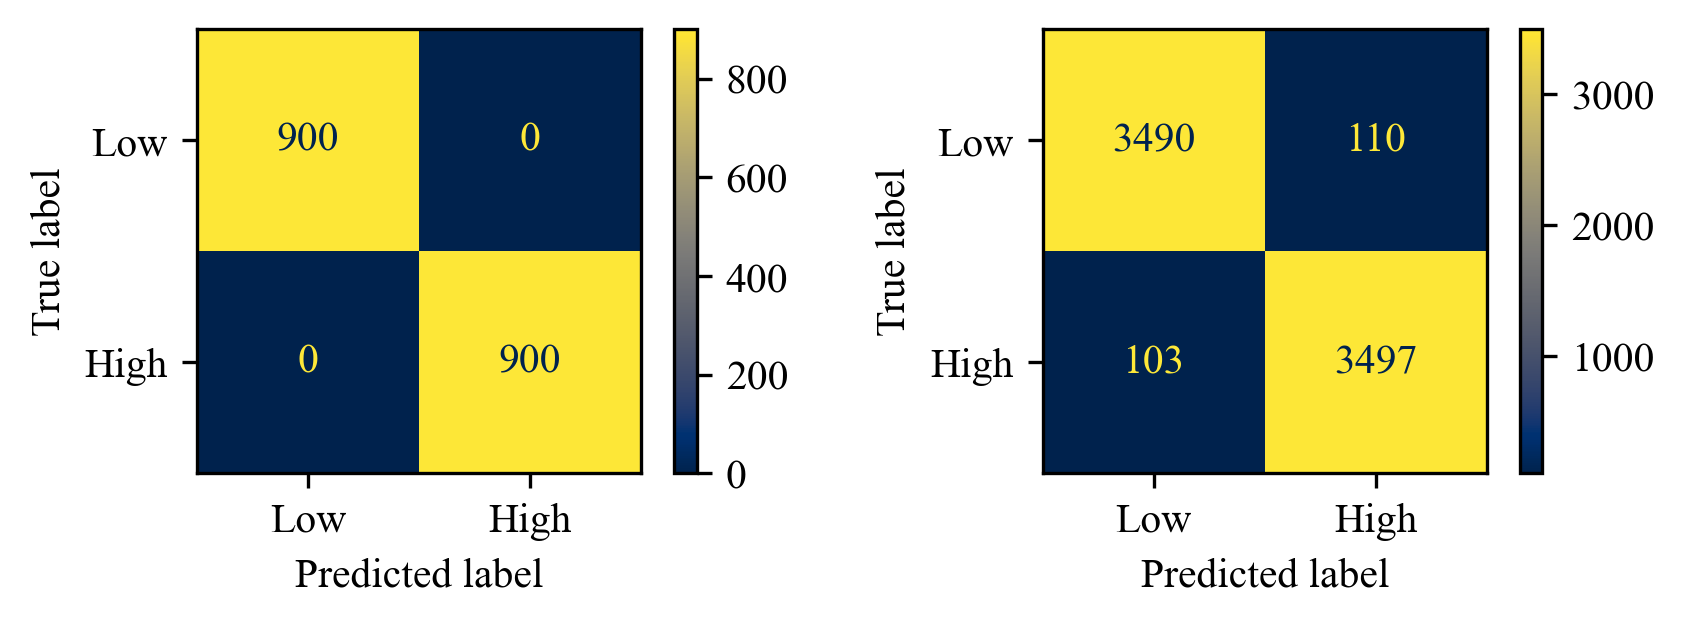

In [ ]:
figsize = plot.cvt_unit((145, 50), "mm")
fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
cmatd64.plot(
    cmap="cividis",
    ax=ax1,
    colorbar=True,
    # values_format=".3f",
    # im_kw={"vmax": 1.0, "vmin": 0.0},
)
cmatd32.plot(
    cmap="cividis",
    ax=ax2,
    colorbar=True,
    # values_format=".3f",
    # im_kw={"vmax": 1.0, "vmin": 0.0},
)

In [7]:
cfg64.figure_path.parent

PosixPath('../reports/figures/ClassifierReflectance/2025-01-23')

In [8]:
# fig.savefig(cfg64.figure_path.parent.parent / "thesis-ch4/comp_contmat_130mm_thesis.svg")

In [ ]:
# data32.filter(
#     # pl.col("target") == -1
data32.groupby(pl.col("dirname").alias("sample id")).agg(
    (
        pl.col("prediction")
        .filter(pl.col("prediction") == 1)
        .count()
        .alias("PredResult: High")
    ),
    (
        pl.col("prediction")
        .filter(pl.col("prediction") == 0)
        .count()
        .alias("PredResult: Low")
    ),
).sort("sample id")  # .filter(pl.col("sample id").is_in([4, 6, 8]))

sample id,PredResult: High,PredResult: Low
i64,u32,u32
0,1085,115
1,136,1064
2,732,468
3,39,1161
4,1182,18
5,8,1192
6,1151,49
7,63,1137
8,1164,36


In [38]:
data32.groupby(
    pl.col("dirname").alias("sample id")
).agg(
    pl.col("target").last(),
    (
        pl.col("prediction")
        .filter(pl.col("prediction") == 1)
        .count()
        .alias("PredResult: High")
    ),
    (
        pl.col("prediction")
        .filter(pl.col("prediction") == 0)
        .count()
        .alias("PredResult: Low")
    ),
).sort("target", "sample id", descending=[True, False])#.filter(pl.col("sample id").is_in([4, 6, 8]))


sample id,target,PredResult: High,PredResult: Low
i64,i64,u32,u32
4,1,1182,18
6,1,1151,49
8,1,1164,36
3,0,39,1161
5,0,8,1192
7,0,63,1137
0,-1,1085,115
1,-1,136,1064
2,-1,732,468


In [14]:
# data64.filter(
#     pl.col("target") == -1
data64.groupby(pl.col("dirname").alias("sample id")).agg(
    (
        pl.col("prediction")
        .filter(pl.col("prediction") == 1)
        .count()
        .alias("PredResult: High")
    ),
    (
        pl.col("prediction")
        .filter(pl.col("prediction") == 0)
        .count()
        .alias("PredResult: Low")
    ),
).sort("sample id").filter(pl.col("sample id").is_in([3, 5, 7]))

sample id,PredResult: High,PredResult: Low
i64,u32,u32
3,0,300
5,0,300
7,0,300
